# Movies on Netflix, Prime Video, Hulu and Disney+

The dataset was taken from Kaggle: https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney

The dataset is an amalgamation of:
- Data that has been scraped and contains a comprehensive list of movies available on various streaming platforms.
- IMDb dataset

**Goal:** predict if title is available on Netflix or not

**Assumption:** rating, year of release, genre, runtime, country, ... might differ between streaming platforms and therefore be useful for the prediction

## Columns
- ID: Movie ID
- Title: Movie Title
- Year: Release Year
- Age: Age restriction
- IMDB: IMDB Rating
- Rotten Tomatoes: Tomatoes Rating
- Netflix, Hulu,Prime Video, Disney+: Streaming Service Platforms
- Type: Movie Genres (empty)
- Genres: Movie Genres
- Directors: Movie Director
- Country: Release in Country
- Language: Available languages/translations
- Runtime: duration of each title in minutes

In [33]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
from pandas_profiling import ProfileReport

In [34]:
def readData(filename):
    df = pd.read_csv(filename, sep=',', encoding='latin-1', index_col='Unnamed: 0')
    profile = ProfileReport(df, title="Pandas Profiling Report")
    #profile.to_file("pandas_report.html")
    return df

In [35]:
df = readData('MoviesOnStreamingPlatforms_updated.csv')

## Preprocessing

### Clean Data
Delete columns or rows, which do not contain enough useful data f.e. nan values and cannot be easily replaced data without further investigation.
- The 'Type' column gets drop, because it provides no variance (constant value).
- The 'Rotten Tomatoes' column gets dropped, as it contains two thirds nan values and a very similar rating is provided through the IMBd column
- Rows that contain nan values for the columns 'IMDb', 'Directors', 'Genres', 'Country' and 'Language' get dropped as well, as
    * there is no easy way to substitute this data without additional data (all columns)
    * substitution with mean, median or 0 values could result into falsifying the data (IMDb)
    * one-hot-encoding would result in a to big dataframe which would tremendously increase the processing time for predictions (directors, language)

In [36]:
# compare null values to total amount of values per column
def compareNanToTotal(df):
    return pd.concat([df.isnull().sum(), df.count()], keys=['null_values', 'total_values'], axis=1)

compareNanToTotal(df)

null_values  total_values
ID                         0         16744
Title                      0         16744
Year                       0         16744
Age                     9390          7354
IMDb                     571         16173
Rotten Tomatoes        11586          5158
Netflix                    0         16744
Hulu                       0         16744
Prime Video                0         16744
Disney+                    0         16744
Type                       0         16744
Directors                726         16018
Genres                   275         16469
Country                  435         16309
Language                 599         16145
Runtime                  592         16152

In [37]:
def dropCols(df):
    del df['Rotten Tomatoes']
    del df['Type']

In [38]:
def dropRows(df):    
    columns = ['IMDb', 'Directors', 'Genres', 'Country', 'Language'] # there are to many directors for one-hot-encoding
    for col in columns:
        df = df[pd.notnull(df[col])]
        
    df.drop_duplicates(inplace=True) # drop duplicate data
    return df

In [39]:
def replaceNan(df):
    columns = ['Runtime']
    for col in columns:
        median = statistics.median(df[col])
        df[col] = df[col].replace(np.nan, median) # fill nan values with median (more robust towards outliers)
    
    df['Age'] = df['Age'].replace(np.nan, 'all') # we assume there is no age constraint for nan values of age column 
    return df

In [40]:
dropCols(df)
df = dropRows(df)
df = replaceNan(df)
compareNanToTotal(df)

null_values  total_values
ID                     0         15386
Title                  0         15386
Year                   0         15386
Age                    0         15386
IMDb                   0         15386
Netflix                0         15386
Hulu                   0         15386
Prime Video            0         15386
Disney+                0         15386
Directors              0         15386
Genres                 0         15386
Country                0         15386
Language               0         15386
Runtime                0         15386

## One Hot Encoding - Age, Genre, Country
### Age

In [41]:
df = pd.get_dummies(df, prefix='age', prefix_sep='_', columns=['Age']) # get dummies for genres

In [42]:
df.tail()

ID                         Title  Year  IMDb  Netflix  Hulu  \
16738  16739  Whispers: An Elephant's Tale  2000   5.0        0     0   
16739  16740     The Ghosts of Buxley Hall  1980   6.2        0     0   
16740  16741                The Poof Point  2001   4.7        0     0   
16741  16742         Sharks of Lost Island  2013   5.7        0     0   
16742  16743            Man Among Cheetahs  2017   6.6        0     0   

       Prime Video  Disney+             Directors  \
16738            0        1        Dereck Joubert   
16739            0        1          Bruce Bilson   
16740            0        1           Neal Israel   
16741            0        1          Neil Gelinas   
16742            0        1  Richard Slater-Jones   

                             Genres        Country Language  Runtime  age_13+  \
16738              Adventure,Family  United States  English     72.0        0   
16739  Comedy,Family,Fantasy,Horror  United States  English    120.0        0   
16740          Comedy,Family,Sci-Fi  United States  English     90.0        0   
16741                   Documentary  United States  English     57.0        0   
16742                   Documentary  United States  English     57.0        0   

       age_16+  age_18+  age_7+  age_all  
16738        0        0       0        1  
16739        0        0       0        1  
16740        0        0       1        0  
16741        0        0       0        1  
16742        0        0       0        1

### Genre

In [43]:
genres = ['horror', 'thriller', 'sci-fi', 'documentary', 'action', 'animation', 'comedy', 'western', 'drama', 'fantasy', 'romance', 'music', 'musical', 'news',
         'adventure', 'sport', 'reality-tv', 'history', 'family', 'biography', 'mystery', 'war', 'crime', 'short', 'film-noir', 'talk-show']

for genre in genres:
    df['genre_' + genre] = 0

In [44]:
df.reset_index(drop=True, inplace=True)
for index, row in df.iterrows():
    if ',' in row.Genres:
        genres = row.Genres.split(',')
        for genre in genres:
            df.loc[df.index[index], 'genre_' + genre.lower()] = 1
    else:
        df.loc[df.index[index], 'genre_' + row.Genres.lower()] = 1

### Country
Retrieve continent name from country first, then perform one hot encoding

In [45]:
def check_continent(data):
    c_entry = []
    for entry in data:
        if str(entry).strip() != 'nan':
            continents = set()
            countries = entry.split(',')
            for country in countries:
                if (country == 'West Germany' or country == 'East Germany' or 
                    country == 'Holy See (Vatican City State)' or country == 'Czechoslovakia' or 
                    country == 'Isle Of Man' or country == 'Reunion' or country == 'Soviet Union' or
                    country == 'Federal Republic of Yugoslavia' or country == 'Yugoslavia' or 
                    country == 'Serbia and Montenegro' or country == 'Kosovo'):
                    continents.add('EU')
                    continue
                if country == 'U.S. Virgin Islands':
                    continents.add('NA')
                    continue   
                if country == 'Korea':
                    continents.add('AS')
                    continue        
                if country == 'The Democratic Republic Of Congo' or "Ivoire" in country:
                    continents.add('AF')
                    continue

                continent = pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country, cn_name_format="default"))
                continents.add(continent)

            c_list = list(continents)
            c_entry.append(','.join([str(elem) for elem in c_list]))    
        else:
            c_entry.append(None)            
            
    return c_entry

In [46]:
df['Continent'] = check_continent(df['Country'])

In [47]:
countries = ['EU', 'AS', 'AF', 'NA', 'SA', 'OC']
for country in countries:
    df[country] = 0

In [48]:
df.reset_index(drop=True, inplace=True)
for index, row in df.iterrows():
    if row.Continent != None: 
        if ',' in row.Continent:
            continents = row.Continent.split(',')
            for continent in continents:
                df.loc[df.index[index], continent] = 1
        else:
            df.loc[df.index[index], row.Continent] = 1

### Compare amount of titles between platforms
As visualized in the pandas profile report, there is a negative correlation between the columns Netflix and Prime Video, which leads to the conclusion that their provided services differ a lot.
For an even better comparison, titles that are both on netflix and prime (323) get removed in the preprocessing. There are 2915 unique titles on Netflix and 11023 titles on Prime Video.
The least amount of titles are available on the smaller platforms Hulu and Disney+.

We combine the unique titles on Netflix with the unique titles on Prime Video.

In [49]:
# remove movies that are both on netflix and prime 
netflix = df.loc[(df['Netflix'] == 1) & (df['Prime Video'] == 0)]
print(netflix.shape)
netflix.head() 

(2915, 51)


ID                              Title  Year  IMDb  Netflix  Hulu  \
0   1                          Inception  2010   8.8        1     0   
1   2                         The Matrix  1999   8.7        1     0   
2   3             Avengers: Infinity War  2018   8.5        1     0   
3   4                 Back to the Future  1985   8.5        1     0   
5   6  Spider-Man: Into the Spider-Verse  2018   8.4        1     0   

   Prime Video  Disney+                                    Directors  \
0            0        0                            Christopher Nolan   
1            0        0               Lana Wachowski,Lilly Wachowski   
2            0        0                      Anthony Russo,Joe Russo   
3            0        0                              Robert Zemeckis   
5            0        0  Bob Persichetti,Peter Ramsey,Rodney Rothman   

                                     Genres  ... genre_short genre_film-noir  \
0          Action,Adventure,Sci-Fi,Thriller  ...           0               0   
1                             Action,Sci-Fi  ...           0               0   
2                   Action,Adventure,Sci-Fi  ...           0               0   
3                   Adventure,Comedy,Sci-Fi  ...           0               0   
5  Animation,Action,Adventure,Family,Sci-Fi  ...           0               0   

   genre_talk-show  Continent  EU  AS  AF  NA  SA  OC  
0                0      EU,NA   1   0   0   1   0   0  
1                0         NA   0   0   0   1   0   0  
2                0         NA   0   0   0   1   0   0  
3                0         NA   0   0   0   1   0   0  
5                0         NA   0   0   0   1   0   0  

[5 rows x 51 columns]

In [50]:
netflix_prime = df.loc[(df['Netflix'] == 1) & (df['Prime Video'] == 1)]
print(netflix_prime.shape) # 322 values in common --> drop or fill in favour for netflix?
netflix_prime.head()

(323, 51)


ID                           Title  Year  IMDb  Netflix  Hulu  \
4    5  The Good, the Bad and the Ugly  1966   8.8        1     0   
6    7                     The Pianist  2002   8.5        1     0   
11  12                        3 Idiots  2009   8.4        1     0   
15  16    Once Upon a Time in the West  1968   8.5        1     0   
31  32                           Drive  2011   7.8        1     0   

    Prime Video  Disney+             Directors                     Genres  \
4             1        0          Sergio Leone                    Western   
6             1        0        Roman Polanski  Biography,Drama,Music,War   
11            1        0       Rajkumar Hirani               Comedy,Drama   
15            1        0          Sergio Leone                    Western   
31            1        0  Nicolas Winding Refn                Crime,Drama   

    ... genre_short genre_film-noir  genre_talk-show  Continent  EU  AS  AF  \
4   ...           0               0                0         EU   1   0   0   
6   ...           0               0                0         EU   1   0   0   
11  ...           0               0                0         AS   0   1   0   
15  ...           0               0                0      EU,NA   1   0   0   
31  ...           0               0                0         NA   0   0   0   

    NA  SA  OC  
4    0   0   0  
6    0   0   0  
11   0   0   0  
15   1   0   0  
31   1   0   0  

[5 rows x 51 columns]

In [51]:
prime = df.loc[(df['Netflix'] == 0) & (df['Prime Video'] == 1)]
print(prime.shape)
prime.head()

(11023, 51)


ID          Title  Year  IMDb  Netflix  Hulu  Prime Video  Disney+  \
3240  3563       Parasite  2019   8.6        0     1            1        0   
3246  3569     Zombieland  2009   7.6        0     1            1        0   
3247  3570  A Quiet Place  2018   7.5        0     1            1        0   
3250  3573      True Grit  2010   7.6        0     1            1        0   
3263  3586  Up in the Air  2009   7.4        0     1            1        0   

                 Directors                           Genres  ... genre_short  \
3240          Bong Joon Ho            Comedy,Drama,Thriller  ...           0   
3246       Ruben Fleischer  Adventure,Comedy,Fantasy,Sci-Fi  ...           0   
3247        John Krasinski              Drama,Horror,Sci-Fi  ...           0   
3250  Ethan Coen,Joel Coen                    Drama,Western  ...           0   
3263         Jason Reitman             Comedy,Drama,Romance  ...           0   

     genre_film-noir  genre_talk-show  Continent  EU  AS  AF  NA  SA  OC  
3240               0                0         AS   0   1   0   0   0   0  
3246               0                0         NA   0   0   0   1   0   0  
3247               0                0         NA   0   0   0   1   0   0  
3250               0                0         NA   0   0   0   1   0   0  
3263               0                0         NA   0   0   0   1   0   0  

[5 rows x 51 columns]

In [52]:
hulu = df.loc[(df['Hulu'] == 1)]
print(hulu.shape)

(852, 51)


In [53]:
disney = df.loc[(df['Disney+'] == 1)]
print(disney.shape)

(550, 51)


### Create "onNetflix" Column

In [54]:
df_comb = prime.append(netflix)
df_comb.head()

ID          Title  Year  IMDb  Netflix  Hulu  Prime Video  Disney+  \
3240  3563       Parasite  2019   8.6        0     1            1        0   
3246  3569     Zombieland  2009   7.6        0     1            1        0   
3247  3570  A Quiet Place  2018   7.5        0     1            1        0   
3250  3573      True Grit  2010   7.6        0     1            1        0   
3263  3586  Up in the Air  2009   7.4        0     1            1        0   

                 Directors                           Genres  ... genre_short  \
3240          Bong Joon Ho            Comedy,Drama,Thriller  ...           0   
3246       Ruben Fleischer  Adventure,Comedy,Fantasy,Sci-Fi  ...           0   
3247        John Krasinski              Drama,Horror,Sci-Fi  ...           0   
3250  Ethan Coen,Joel Coen                    Drama,Western  ...           0   
3263         Jason Reitman             Comedy,Drama,Romance  ...           0   

     genre_film-noir  genre_talk-show  Continent  EU  AS  AF  NA  SA  OC  
3240               0                0         AS   0   1   0   0   0   0  
3246               0                0         NA   0   0   0   1   0   0  
3247               0                0         NA   0   0   0   1   0   0  
3250               0                0         NA   0   0   0   1   0   0  
3263               0                0         NA   0   0   0   1   0   0  

[5 rows x 51 columns]

In [55]:
# init with 0 because there are more movies on prime video than netflix
df_comb['onNetflix'] = 0 

for index, value in df_comb.Netflix.items():
    if value == 1:
        df_comb.loc[df.index[index], 'onNetflix'] = 1
        #df.onNetflix[index] = 1 # 

In [56]:
df = df_comb.sort_values(by='ID', ascending=True) # sort by ID ascending
df.head()

ID                              Title  Year  IMDb  Netflix  Hulu  \
0   1                          Inception  2010   8.8        1     0   
1   2                         The Matrix  1999   8.7        1     0   
2   3             Avengers: Infinity War  2018   8.5        1     0   
3   4                 Back to the Future  1985   8.5        1     0   
5   6  Spider-Man: Into the Spider-Verse  2018   8.4        1     0   

   Prime Video  Disney+                                    Directors  \
0            0        0                            Christopher Nolan   
1            0        0               Lana Wachowski,Lilly Wachowski   
2            0        0                      Anthony Russo,Joe Russo   
3            0        0                              Robert Zemeckis   
5            0        0  Bob Persichetti,Peter Ramsey,Rodney Rothman   

                                     Genres  ... genre_film-noir  \
0          Action,Adventure,Sci-Fi,Thriller  ...               0   
1                             Action,Sci-Fi  ...               0   
2                   Action,Adventure,Sci-Fi  ...               0   
3                   Adventure,Comedy,Sci-Fi  ...               0   
5  Animation,Action,Adventure,Family,Sci-Fi  ...               0   

  genre_talk-show  Continent  EU  AS  AF  NA  SA  OC  onNetflix  
0               0      EU,NA   1   0   0   1   0   0          1  
1               0         NA   0   0   0   1   0   0          1  
2               0         NA   0   0   0   1   0   0          1  
3               0         NA   0   0   0   1   0   0          1  
5               0         NA   0   0   0   1   0   0          1  

[5 rows x 52 columns]

## Data Exploration 

In [33]:
# count movies per column (platforms or continent)
def movies_count(col, count=False):
    if count==False:
        print('Movies in {} are {}'. format(col, df[col].sum()))
    else:
        return df[col].sum()

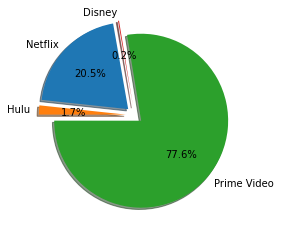

In [34]:
# movies per platform
labels = 'Netflix', 'Hulu', 'Prime Video', 'Disney'
size = [movies_count('Netflix', count=True), 
        movies_count('Hulu', count=True),
        movies_count('Prime Video', count=True),
        movies_count('Disney+', count=True)]

explode = (0.1, 0.1, 0.1, 0.1)

# plotting
fig1, ax1 = plt.subplots()

ax1.pie(size,
       labels = labels,
       autopct = '%1.1f%%',
       explode = explode,
       shadow = True,
       startangle = 100)

ax1.axis = ('equal')
plt.show()

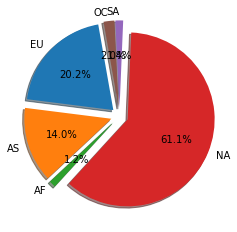

In [35]:
# movies per continent
labels = 'EU', 'AS', 'AF', 'NA', 'SA', 'OC'
size = [movies_count('EU', count=True), 
        movies_count('AS', count=True),
        movies_count('AF', count=True),
        movies_count('NA', count=True),
        movies_count('SA', count=True),
        movies_count('OC', count=True)]

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

#plotting
fig1, ax1 = plt.subplots()

ax1.pie(size,
       labels = labels,
       autopct = '%1.1f%%',
       explode = explode,
       shadow = True,
       startangle = 100)

ax1.axis = ('equal')
plt.show()

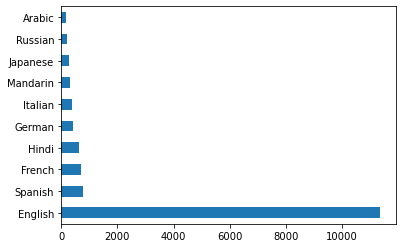

In [36]:
# do languages correlate with continent plot?
s = df['Language'].str.split(',').apply(pd.Series,1).stack() # split index
s.index = s.index.droplevel(-1) # reduce index
s.name = 'Language'

df_language = pd.DataFrame(s)
df_language['Language'].value_counts()[:10].plot(kind='barh')
plt.show()

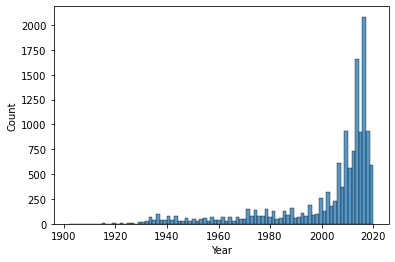

In [37]:
#checking years -> So we have movies starting from 1900, but mostly the data is from 2000 onwards
sns.histplot(df['Year'])
plt.show()

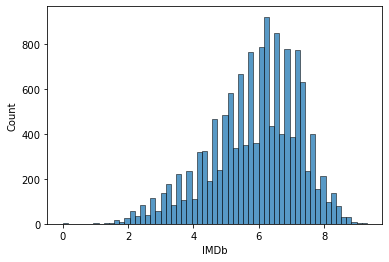

Minimum IMDb rating:  0.0
Maximum IMDb rating:  9.3


In [38]:
# checking imdb ratings
sns.histplot(df['IMDb'])
plt.show()
print('Minimum IMDb rating: ', df['IMDb'].min())
print('Maximum IMDb rating: ', df['IMDb'].max())

In [39]:
imdb_top_ten = df.nlargest(10, 'IMDb')
imdb_top_ten

ID                                    Title  Year  IMDb  Netflix  \
6128  6567                               Square One  2019   9.3        0   
6387  6838  Steven Banks: Home Entertainment Center  1989   9.3        0   
6761  7221                       Down, But Not Out!  2015   9.3        0   
6959  7427                                   Bounty  2011   9.3        0   
923    948                                Natsamrat  2016   9.1        1   
7021  7492                           Finding Family  2013   9.1        0   
7943  8459                           Where's Daddy?  2017   9.1        0   
6545  7003                Escape from Firebase Kate  2015   9.0        0   
6805  7268                        A Dog Named Gucci  2015   9.0        0   
4450  4830                          The Mountain II  2016   8.9        0   

      Hulu  Prime Video  Disney+                Directors  \
6128     0            1        0                 Danny Wu   
6387     0            1        0           Tom McLoughlin   
6761     0            1        0        Miguel GaudÃªncio   
6959     0            1        0          Roger Donaldson   
923      0            0        0         Mahesh Manjrekar   
7021     0            1        0  Chris Leslie,Oggi Tomic   
7943     0            1        0              Rel Dowdell   
6545     0            1        0              Paul Kakert   
6805     0            1        0           Gorman Bechard   
4450     0            1        0             Alper Caglar   

                                Genres  ... genre_film-noir genre_talk-show  \
6128           Documentary,Drama,Music  ...               0               0   
6387                            Comedy  ...               0               0   
6761                 Documentary,Sport  ...               0               0   
6959   Adventure,Drama,History,Romance  ...               0               0   
923                       Drama,Family  ...               0               0   
7021    Documentary,Family,History,War  ...               0               0   
7943                       Documentary  ...               0               0   
6545                       Documentary  ...               0               0   
6805  Documentary,Biography,Drama,News  ...               0               0   
4450                  Action,Drama,War  ...               0               0   

      Continent  EU  AS  AF  NA  SA  OC  onNetflix  
6128         NA   0   0   0   1   0   0          0  
6387         NA   0   0   0   1   0   0          0  
6761         EU   1   0   0   0   0   0          0  
6959   OC,EU,NA   1   0   0   1   0   1          0  
923          AS   0   1   0   0   0   0          1  
7021         EU   1   0   0   0   0   0          0  
7943         NA   0   0   0   1   0   0          0  
6545         NA   0   0   0   1   0   0          0  
6805         NA   0   0   0   1   0   0          0  
4450         AS   0   1   0   0   0   0          0  

[10 rows x 52 columns]

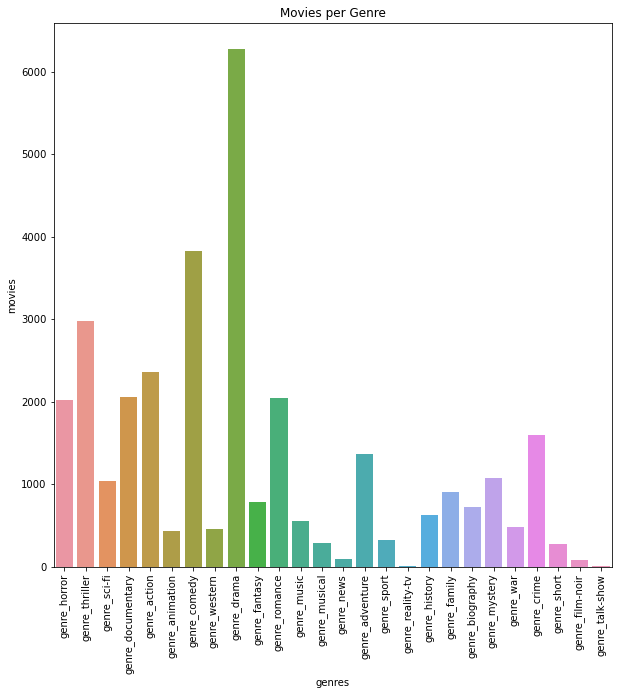

In [40]:
# movies per genre
genres_columns = [col for col in df.columns if col.find("genre_") != -1]
data = []
for col in genres_columns:
    size = len(df.loc[(df[col]==1)])
    data.append(size)
    
genre_value_counts = pd.DataFrame(data, genres_columns)
plt.figure(figsize=(10,10))
ax = sns.barplot(x = genres_columns, y = genre_value_counts[0])
ax.set(xlabel='genres', ylabel='movies')
ax.set_title('Movies per Genre')
plt.xticks(rotation=90)
plt.show()

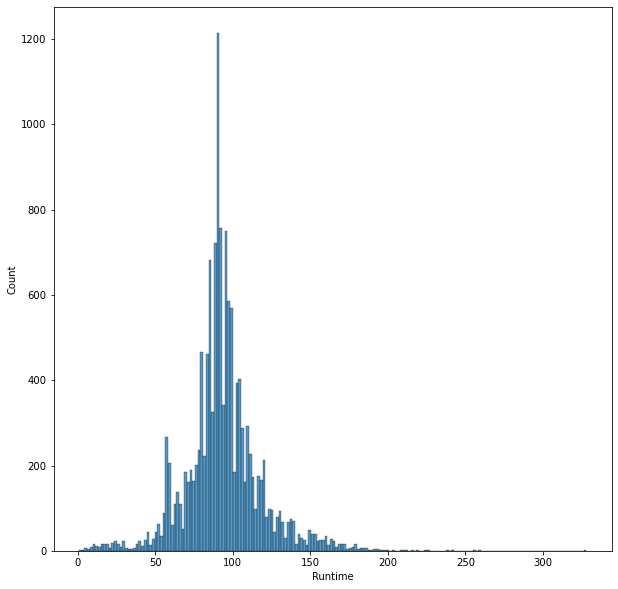

In [41]:
plt.figure(figsize=(10,10))
sns.histplot(df['Runtime'])
plt.show()

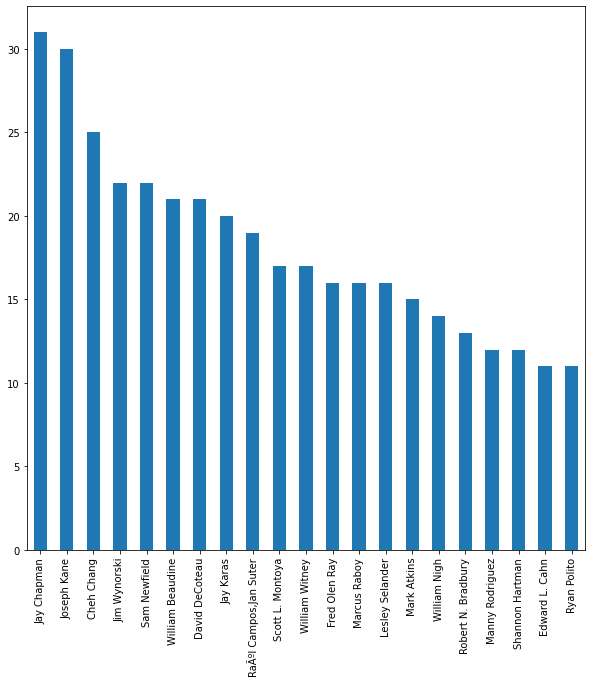

In [42]:
# find director, which has the maximum number of movies
directors = df['Directors'].value_counts()
directors = directors.loc[directors > 10]

plt.figure(figsize=(10,10))
directors.plot(kind='bar')
plt.show()

## Predictions
Predict if title is available on Netflix or not (available on Prime Video instead).

In [57]:
# predict if on netflix or not
y = df.onNetflix
    
# X = all the features other features
X = df.drop(['ID', 'onNetflix', 'Netflix', 'Prime Video', 'Genres', 'Continent', 'Title', 'Directors', 'Country', 'Language'], axis = 1) # ID

X.head()

Year  IMDb  Hulu  Disney+  Runtime  age_13+  age_16+  age_18+  age_7+  \
0  2010   8.8     0        0    148.0        1        0        0       0   
1  1999   8.7     0        0    136.0        0        0        1       0   
2  2018   8.5     0        0    149.0        1        0        0       0   
3  1985   8.5     0        0    116.0        0        0        0       1   
5  2018   8.4     0        0    117.0        0        0        0       1   

   age_all  ...  genre_crime  genre_short  genre_film-noir  genre_talk-show  \
0        0  ...            0            0                0                0   
1        0  ...            0            0                0                0   
2        0  ...            0            0                0                0   
3        0  ...            0            0                0                0   
5        0  ...            0            0                0                0   

   EU  AS  AF  NA  SA  OC  
0   1   0   0   1   0   0  
1   0   0   0   1   0   0  
2   0   0   0   1   0   0  
3   0   0   0   1   0   0  
5   0   0   0   1   0   0  

[5 rows x 42 columns]

In [58]:
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, r2_score

def evaluateModel(model, train_x, test_x, train_y, test_y, model_name):
    train_predict = model.predict(train_x)
    test_predict = model.predict(test_x)

    r2 = r2_score(train_y, train_predict)
    error = max_error(train_y, train_predict)
    mse = mean_squared_error(train_y, train_predict)

    print("{0} train set metrics: ".format(model_name))
    print("R-Squared: {0}\nMax Error: {1}\nMSE: {2}\n".format(r2, error, mse))

    r2 = r2_score(test_y, test_predict)
    error = max_error(test_y, test_predict)
    mse = mean_squared_error(test_y, test_predict)

    print("{0} test set metrics: ".format(model_name))
    print("R-Squared: {0}\nMax Error: {1}\nMSE: {2}\n".format(r2, error, mse))
    
    print("{0} \nAccuracy: {1}".format(model_name, model.score(test_x, test_y)))

    return train_predict, test_predict

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [60]:
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = StandardScaler()  
    scaler.fit(data)  
    return scaler.transform(data)  

# apply same transformation to both train and test data
train_normalized = MinMaxScaler().fit_transform(X_train)
test_normalized = MinMaxScaler().fit_transform(X_test)
train_standardized = standardize_data(X_train)  
test_standardized = standardize_data(X_test)    

### Logistic Regression

We use the logistic regression as a classification model.

Although the accuracy score around 80% is promising, the negative value for R2 is bad, meaning that the chosen model fits the data really poorly.

The result of our confusion matrix is telling us that we have 3558+97 correct predictions and 868+77 incorrect predictions.

From our values for precision and recall we can gather that our classification is better to find class 0 (Prime Video) over class 1 (Netflix).

A possible interpretation for the high accuracy but varying values for precision and recall could be the imbalance within the dataset, where the majority of titles belong to Prime Video (around 11.000) opposed to a minority that belongs to Netflix (around 3000).

In [61]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=400).fit(X_train, y_train) # fit logistic model
train_predict, test_predict = evaluateModel(log_reg, X_train, X_test, y_train, y_test, model_name="Logistic Regression")

Logistic Regression train set metrics: 
R-Squared: -0.2574597753807286
Max Error: 1
MSE: 0.20775326622403084

Logistic Regression test set metrics: 
R-Squared: -0.23924710108259495
Max Error: 1
MSE: 0.20543478260869566

Logistic Regression 
Accuracy: 0.7945652173913044


In [62]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegression(max_iter=400), X_train, y_train, cv=5)
# training data gets split in k=5 samples
# each sample is used to train data k-1 times
# prevents overfitting

print(scores) # returns 5 scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) # little improvement of model when using cv

[0.78961456 0.78907923 0.79978587 0.79164435 0.7873594 ]
Accuracy: 0.79 (+/- 0.01)


In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, test_predict)
print(confusion_matrix)

[[3558   77]
 [ 868   97]]


In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      3635
           1       0.56      0.10      0.17       965

    accuracy                           0.79      4600
   macro avg       0.68      0.54      0.53      4600
weighted avg       0.75      0.79      0.73      4600



### Decision Tree

The Decision Tree Classifier from sklearn is applied for this classification problem. 

Beginning from the root node we can tell how a decision/prediction is made by looking a the leaves of the tree in the visualization. Decisions are based on certain thresholds for the different columns from the trainings data, meaning that if the value is smaller/larger than x, decision y is made.

A couple iterations where made to find the best depth for the decision tree. Both the information gain and gini index criterion (to measure the quality of a split) were used to determine the best tree depth - meaning the depth resulting in the best score.

When examining the decision tree with depth 5 using information gain criterion we can see 'genre_animation', 'genre_family', 'age_7+', 'runtime', 'Hulu', 'NA' (North America) and 'IMDb' where important factors in regards to the outcome of the classification. 

f.e. Classification for Netflix appears to be influenced by kids content as it uses the indicators 'genre_family' and 'age_7+'. 

f.e. Classification for Prime shows that newer titles which where released after 2018 on Hulu where also available on Prime Video, but not on Netflix.

When examining the decision tree with depth 6 using gini index criterion we can see 'age_18+', 'genre_history', 'genry_comedy', 'genre_action', 'Hulu', 'NA' (North America), 'genre_crime', 'IMDb' and runtime where important factors in regards to the outcome of the classification. 

f.e. Similar to before Hulu seems to be a deciding factor for classifying if titles are available on Netflix or on Prime Video. Furthermore all titles that are not on Hulu, have a runtime longer than 143 minutes and belong to the genre crime can be assigned to Netflix.

When looking at the performance metrics of the classification we see a reoccuring pattern, with good accuracy but bad R2 score.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# build decision tree classifier to predict whether title is on netflix or prime
def makeCV(depth, criterion, *args):
    clf = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth = depth)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=10) # normally between 5 and 10
    if args:
        plt.figure(figsize=(args[0], args[1]))
        a = tree.plot_tree(clf, 
              feature_names=X_train.columns, 
              class_names=['onPrime', 'onNetflix'],                    
              filled=True, 
              rounded=True, 
              fontsize=14)
        
        plt.savefig('./plots/tree/tree_' + str(depth) + '_' + criterion +'.jpg',format='jpg',bbox_inches = "tight")
    return scores.mean()

In [52]:
ig_scores = []
gini_scores = []
for depth in range(1, 11):
    ig_scores.append( (depth, makeCV(depth, 'entropy') ) )
    gini_scores.append( (depth, makeCV(depth, 'gini') ) )

In [53]:
for ig_score, gini_score in zip(ig_scores, gini_scores):
    print('Depth:', ig_score[0], 'IG-Score:', ig_score[1], 'Gini-Score:', gini_score[1] )

Depth: 1 IG-Score: 0.7911758023093288 Gini-Score: 0.7911758023093288
Depth: 2 IG-Score: 0.8125940130040326 Gini-Score: 0.8125940130040326
Depth: 3 IG-Score: 0.8135577251894031 Gini-Score: 0.8132365260459341
Depth: 4 IG-Score: 0.8130219342637666 Gini-Score: 0.8132356080062243
Depth: 5 IG-Score: 0.8174114263812482 Gini-Score: 0.8150563102607002
Depth: 6 IG-Score: 0.8189102409624729 Gini-Score: 0.8224464151696882
Depth: 7 IG-Score: 0.8189102409624729 Gini-Score: 0.8220174611152806
Depth: 8 IG-Score: 0.816128465886792 Gini-Score: 0.8163422543842133
Depth: 9 IG-Score: 0.8212670784074765 Gini-Score: 0.8192331614303976
Depth: 10 IG-Score: 0.8174117706461393 Gini-Score: 0.8221239537216183


In [54]:
print('Best tree Depth for information gain criterion: ', max(ig_scores,key=lambda item:item[1])[0])
print('Best Depth with for gini index criterion:       ', max(gini_scores,key=lambda item:item[1])[0])

Best tree Depth for information gain criterion:  9
Best Depth with for gini index criterion:        6


Accuracy for Tree with depth 5 using information gain criterion: 0.817


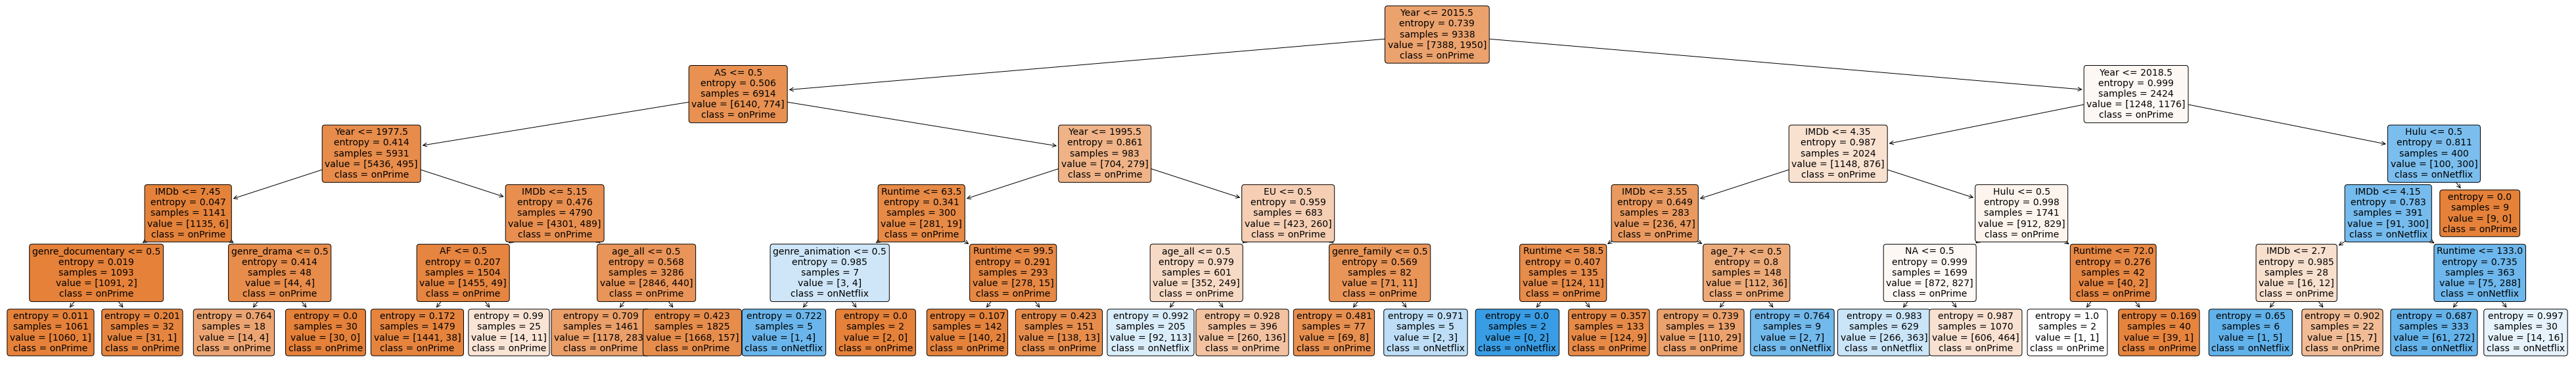

In [55]:
# chose depth of 5 for easier visualization and interpretation as there is only a small change in accuracy compared to the best depth of 9
print('Accuracy for Tree with depth 5 using information gain criterion: {:.3f}'.format(makeCV(5, 'entropy', 70, 10)))

Accuracy for Tree with depth 5 using gini index criterion: 0.822


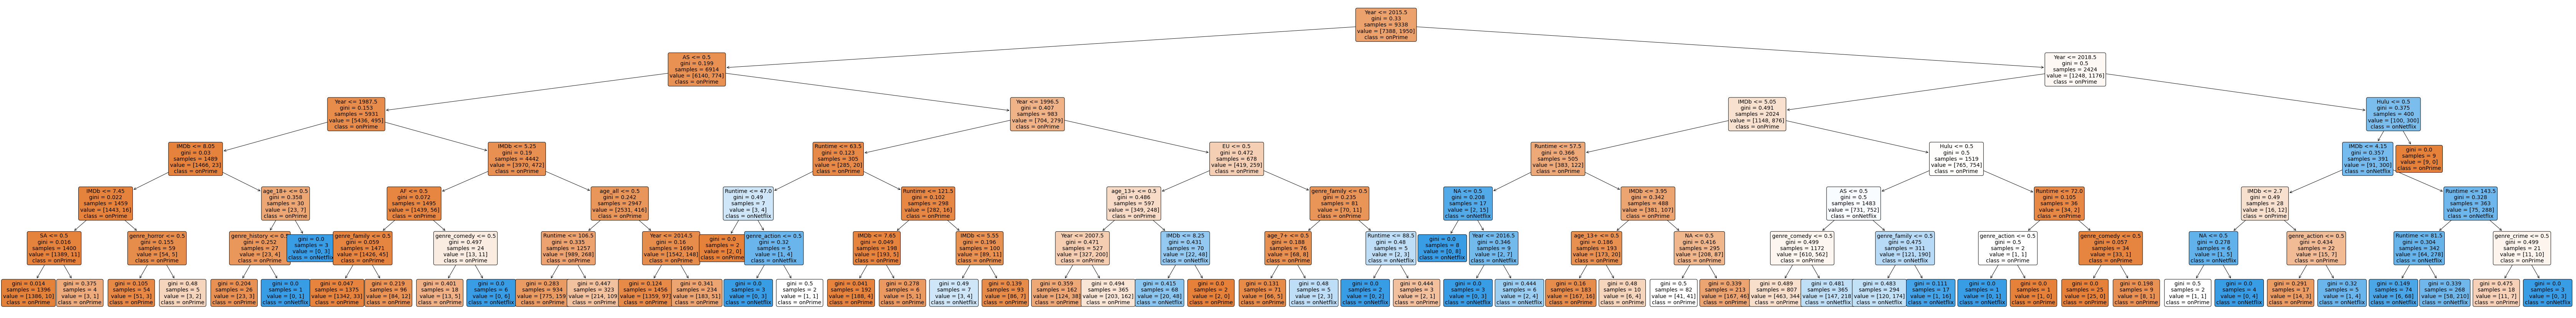

In [56]:
print('Accuracy for Tree with depth 5 using gini index criterion: {:.3f}'.format(makeCV(6, 'gini', 120, 15)))

In [57]:
clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth = 6)
clf.fit(X_train, y_train)

train_predict, test_predict = evaluateModel(clf, X_train, X_test, y_train, y_test, model_name="Decision Tree")        

Decision Tree train set metrics: 
R-Squared: 0.010236558244137828
Max Error: 1
MSE: 0.16352538016705934

Decision Tree test set metrics: 
R-Squared: -0.04909807499055652
Max Error: 1
MSE: 0.17391304347826086

Decision Tree 
Accuracy: 0.8260869565217391


### Neural Network

The MLPRegressor from sklearn is used to build multiple neural network which varying activation functions and layer sizes. 

Examining the results we can see the logistic function performs better with less layers as scores seems to decrease with the increase of hidden layers.

Tanh and relu activation functions seem to follow the same trends in the change of amount of layers and neurons per layer.

When comparing the overall accuracy scores for normalized and standardized data, we can see tanh and logistic performing a little bit better with standardized data and relu performing better using normalized data.

It is hard to tell which is the "right" amount of layers and neurons as none of the scores are very good with the best accuracy being as close to 30%. 
Results could be influenced by local minima when using the wrong learning rate and too many layers or neurons could result in overfitting.

The standardized data provides slightly better results when compared to using normalized data.

In [58]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

In [59]:
def makeNN(data, activation, size):
    # learning rate und maxiterations anpassen
    regr = MLPRegressor(activation=activation, solver='sgd', learning_rate_init=0.04, hidden_layer_sizes=size, max_iter=5000)
    regr.fit(data, y_train)
    return regr

In [60]:
def testNN(sizes, train_x, test_x):
    scores = []
    for activation in ['tanh', 'relu', 'logistic']:
        for size in sizes: 
            regr = makeNN(train_x, activation, size)
            score = regr.score(test_x, y_test)
            print("{0}: Score: {1} - Hidden Layer Size: {2}".format(activation, score, size))
        print()
    print()

In [61]:
def testLayerSizes(train_x, test_x):    
    sizes = [(2,), (5,), (10,), (20,), (30,), (100,)]
    print('Testing for 1 Hidden Layer:')
    testNN(sizes, train_x, test_x)
    
    sizes = [(2,5), (5,2), (10,20), (20,10), (50,50)]
    print('Testing for 2 Hidden Layers:')
    testNN(sizes, train_x, test_x)
    
    sizes = [(2,2,2,), (10, 10, 10), (10, 20, 30), (20, 20, 20,)]#, (50, 40, 30, 20, 10, 5)] 
    print('Testing for 3 Hidden Layers:')
    testNN(sizes, train_x, test_x)
    
    print('Testing for 4 Hidden Layers:')
    testNN([(2,4,6,8,)], train_x, test_x)

In [62]:
testLayerSizes(train_standardized, test_standardized)

Testing for 1 Hidden Layer:
tanh: Score: 0.26497637716851696 - Hidden Layer Size: (2,)
tanh: Score: 0.26302180215371906 - Hidden Layer Size: (5,)
tanh: Score: 0.2798089847736851 - Hidden Layer Size: (10,)
tanh: Score: 0.2551300496189338 - Hidden Layer Size: (20,)
tanh: Score: 0.20087941776557816 - Hidden Layer Size: (30,)
tanh: Score: 0.07517257537579713 - Hidden Layer Size: (100,)

relu: Score: 0.26193975233177125 - Hidden Layer Size: (2,)
relu: Score: 0.2923126329435509 - Hidden Layer Size: (5,)
relu: Score: 0.1485839513234667 - Hidden Layer Size: (10,)
relu: Score: 0.26692542061941404 - Hidden Layer Size: (20,)
relu: Score: 0.2589421241513884 - Hidden Layer Size: (30,)
relu: Score: 0.07249356210191449 - Hidden Layer Size: (100,)

logistic: Score: 0.24798666182994866 - Hidden Layer Size: (2,)
logistic: Score: 0.2703593488835718 - Hidden Layer Size: (5,)
logistic: Score: 0.2820713006684339 - Hidden Layer Size: (10,)
logistic: Score: 0.2824025318931356 - Hidden Layer Size: (20,)
logist

In [63]:
testLayerSizes(train_normalized, test_normalized)

Testing for 1 Hidden Layer:
tanh: Score: 0.21060353755683092 - Hidden Layer Size: (2,)
tanh: Score: 0.17297587146697235 - Hidden Layer Size: (5,)
tanh: Score: 0.1999795415645096 - Hidden Layer Size: (10,)
tanh: Score: 0.20180293715799424 - Hidden Layer Size: (20,)
tanh: Score: 0.17432139348207687 - Hidden Layer Size: (30,)
tanh: Score: 0.19656726250242584 - Hidden Layer Size: (100,)

relu: Score: 0.27721358398128915 - Hidden Layer Size: (2,)
relu: Score: 0.17492420525445673 - Hidden Layer Size: (5,)
relu: Score: 0.24016704512652165 - Hidden Layer Size: (10,)
relu: Score: 0.2733053256924811 - Hidden Layer Size: (20,)
relu: Score: 0.2669078461448725 - Hidden Layer Size: (30,)
relu: Score: 0.21351351726385004 - Hidden Layer Size: (100,)

logistic: Score: 0.16293653347997727 - Hidden Layer Size: (2,)
logistic: Score: 0.15730931967511708 - Hidden Layer Size: (5,)
logistic: Score: 0.16237364241683439 - Hidden Layer Size: (10,)
logistic: Score: 0.1747253403408352 - Hidden Layer Size: (20,)
lo

In [64]:
regr = makeNN(train_standardized, 'tanh', (10,))
score = regr.score(test_standardized, y_test)

train_predict, test_predict = evaluateModel(regr, train_standardized, test_standardized, y_train, y_test, model_name="Neural Network")

Neural Network train set metrics: 
R-Squared: 0.3553961812976749
Max Error: 1.1901722229232017
MSE: 0.1064992704958246

Neural Network test set metrics: 
R-Squared: 0.2866337169078761
Max Error: 1.1997823229341424
MSE: 0.1182574864685007

Neural Network 
Accuracy: 0.2866337169078761


In [65]:
regr = makeNN(train_normalized, 'tanh', (10, 20, 30))
score = regr.score(test_normalized, y_test)

train_predict, test_predict = evaluateModel(regr, train_normalized, test_normalized, y_train, y_test, model_name="Neural Network")

Neural Network train set metrics: 
R-Squared: 0.32973158106200817
Max Error: 1.0766251742926518
MSE: 0.11073948925246786

Neural Network test set metrics: 
R-Squared: 0.28223557658847176
Max Error: 1.4420823087329886
MSE: 0.11898658319151104

Neural Network 
Accuracy: 0.28223557658847176


### kNN
KNeighborsRegressor from sklearn is used as a non-linear classifier. 

The best value of k is determined within the range of 2-30 using cross validation and different input data (default data without preprocessing, standardized data, normalized data).

At first glance it seems that the higher our number of neighbors (k) the better the results. However at a certain point increaing the number of neighbors shows no significant effect anymore, suggesting that the ideal amount of neighbors seems to be within the range of 20-30.

Comparing the scores we see manhattan distance and euclidian distance share similar metrics for the train data however when it comes to the test metrics, manhattan distance performs better. Also the Accuracy is better for manhattan distance.

In [65]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

def findBestK(train_x, train_y):
    knn = KNeighborsRegressor()
    grid_search = GridSearchCV(estimator=knn, cv=KFold(n_splits=10, shuffle=True), param_grid={"n_neighbors": [2, 5, 10, 15, 20, 25, 30]}, scoring='neg_mean_squared_error')
    grid_search.fit(train_x, train_y)

    print("Best: {0} with score: {1}".format(grid_search.best_params_, grid_search.best_score_))
    for mean, std, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score'], grid_search.cv_results_['params']):
            print("%r: Mean score: %0.3f (+/- %0.3f)" % (params, mean, std))

    return grid_search.best_estimator_

In [66]:
print("CV without preprocessing:")
kNN = findBestK(X_train, y_train)
print()

print("CV with standardized data:")
standardized_data = standardize_data(X_train)
kNN_std = findBestK(standardized_data, y_train)
print()

print("CV with normalized data:")
kNN_std = findBestK(train_normalized, y_train)
print()

CV without preprocessing:
Best: {'n_neighbors': 15} with score: -0.12288064591233896
{'n_neighbors': 2}: Mean score: -0.161 (+/- 0.006)
{'n_neighbors': 5}: Mean score: -0.133 (+/- 0.005)
{'n_neighbors': 10}: Mean score: -0.125 (+/- 0.006)
{'n_neighbors': 15}: Mean score: -0.123 (+/- 0.006)
{'n_neighbors': 20}: Mean score: -0.123 (+/- 0.007)
{'n_neighbors': 25}: Mean score: -0.124 (+/- 0.006)
{'n_neighbors': 30}: Mean score: -0.124 (+/- 0.006)

CV with standardized data:
Best: {'n_neighbors': 20} with score: -0.13639528580871266
{'n_neighbors': 2}: Mean score: -0.179 (+/- 0.006)
{'n_neighbors': 5}: Mean score: -0.148 (+/- 0.006)
{'n_neighbors': 10}: Mean score: -0.139 (+/- 0.006)
{'n_neighbors': 15}: Mean score: -0.137 (+/- 0.005)
{'n_neighbors': 20}: Mean score: -0.136 (+/- 0.005)
{'n_neighbors': 25}: Mean score: -0.137 (+/- 0.006)
{'n_neighbors': 30}: Mean score: -0.138 (+/- 0.006)

CV with normalized data:
Best: {'n_neighbors': 30} with score: -0.1323111426559756
{'n_neighbors': 2}: 

In [70]:
# best results with 30 neighbours and non standardized or normalized data
# euclidian distance
knn = KNeighborsRegressor(n_neighbors = 30)
knn.fit(train_normalized, y_train)

train_predict, test_predict = evaluateModel(knn, train_normalized, X_test, y_train, y_test, model_name="k-Nearest Neighbours")

k-Nearest Neighbours train set metrics: 
R-Squared: 0.25388487390810055
Max Error: 0.9666666666666667
MSE: 0.12327062659146618

k-Nearest Neighbours test set metrics: 
R-Squared: -1.0842562593096758
Max Error: 0.8333333333333334
MSE: 0.3455152173913043

k-Nearest Neighbours 
Accuracy: -1.0842562593096758


In [71]:
# manhattan distance
knn = KNeighborsRegressor(n_neighbors=30, p=1)
knn.fit(train_normalized, y_train)

train_predict, test_predict = evaluateModel(knn, train_normalized, test_normalized, y_train, y_test, model_name="k-Nearest Neighbours (Manhattan)")

k-Nearest Neighbours (Manhattan) train set metrics: 
R-Squared: 0.26151173474503175
Max Error: 0.9666666666666667
MSE: 0.12201054234787369

k-Nearest Neighbours (Manhattan) test set metrics: 
R-Squared: 0.19659486584959307
Max Error: 1.0
MSE: 0.13318357487922705

k-Nearest Neighbours (Manhattan) 
Accuracy: 0.19659486584959307


### PCA
The principal component analysis is used for reducing dimensionality from 42 to 35. More precisely, 95% of the variance in the data is explained by these components. Using the standardized data as input is important in PCA since it is a variance maximizing exercise.

In [76]:
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [77]:
pca = PCA(0.95)
transformed = pd.DataFrame(pca.fit_transform(train_standardized))
print("Number of components needed to explain 95% of variance: {0}".format(len(pca.components_)))

Number of components needed to explain 95% of variance: 35


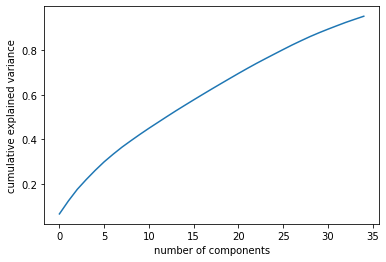

In [78]:
# Access the number of needed dimensions by plotting the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

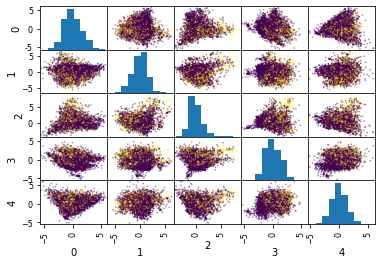

In [79]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(transformed.iloc[:, :5], c=y_train, s=10)

### T-SNE

T-SNE is used to reduce the dimensionality of the data to 2 dimensions. We render multiple scatter plots using varying perplexity values between 5 and 50 and 2000 iterations.
For the testing purposes a randomized sample is generated and used for faster computation of T-SNE.

Perplexity values in the range of 10 to 20 seem to provide the best visual results, allthough it is hard to tell as the plots show multiple data clusters that have mixed distributions of both classes and therefore cannot clearly be labeled as a "Netflix" or "Prime Video". Unfortunately there is no visible distinct "Netflix" cluster, which corresponds to the results of previous models used for prediction. Perplexities bigger in the range of 25-50 seem to lead to more scattered data and less distinct clusters.

We can tell from the plots that using standardized and normalized data is having a huge inpact on the clusters that form. Plots for standardized and normalized data do not vary greatly.

In [80]:
def plotTSNE(data, target, title, n_iter=2000):
    perplexities = [5, 10, 15, 20, 25, 30, 35, 50]
    for idx, p in enumerate(perplexities):    
        tsne = TSNE(n_components=2, perplexity=p, n_iter=n_iter)
        tsne_obj = tsne.fit_transform(data)
        tsne_df = pd.DataFrame({'X':tsne_obj[:,0], 'Y':tsne_obj[:,1], 'target': target})
        sns.scatterplot(x="X", y="Y", hue="target", alpha= 0.3, palette=['blue', 'red'], data=tsne_df, legend="full");
        plt.title("Perplexity: {0}".format(p))
        plt.show()
        plt.savefig('./plots/'+ title + str(p) +'.png')

In [81]:
# make randomly generated subset for data for faster computation of tsne
import random
N = 1000
indices = random.sample(range(1, len(X_train)), N)

X_sample_standardized = pd.DataFrame(train_standardized).iloc[indices]
X_sample_normalized = pd.DataFrame(train_standardized).iloc[indices]
X_sample = X_train.iloc[indices]
y_sample = y_train.iloc[indices]

Data without preprocessing: 


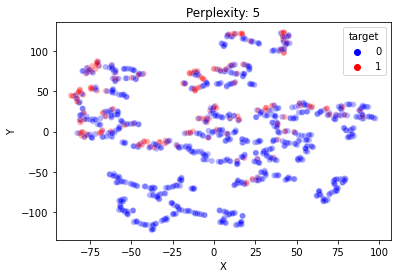

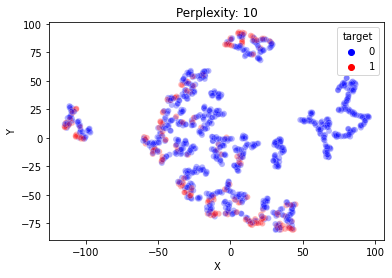

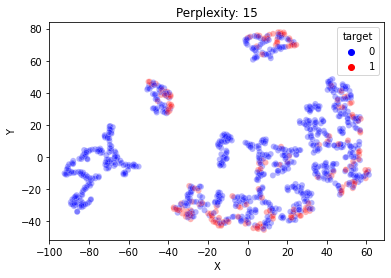

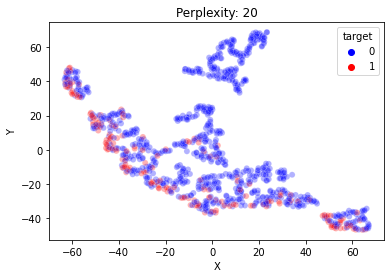

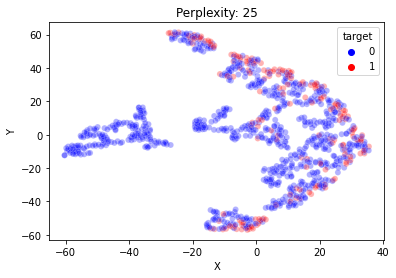

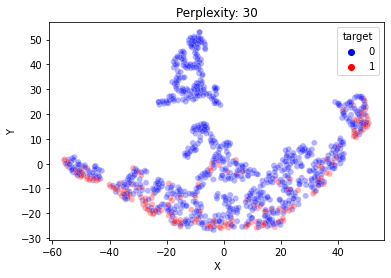

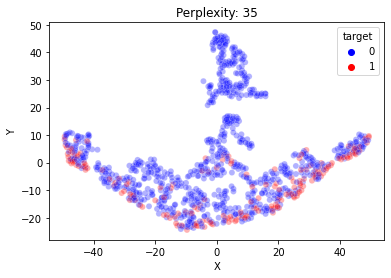

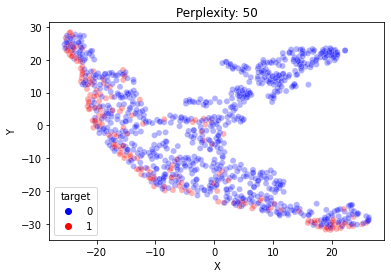

Standardized data: 


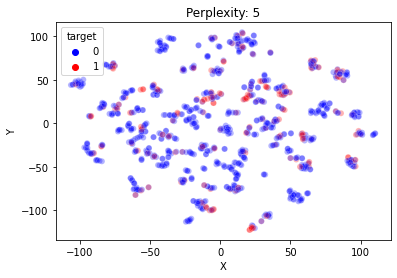

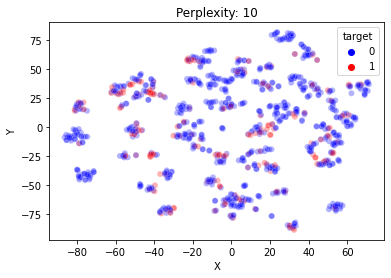

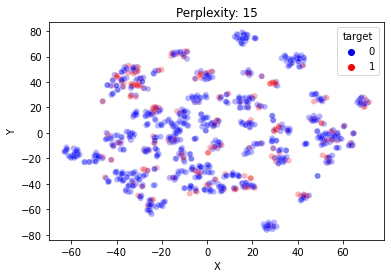

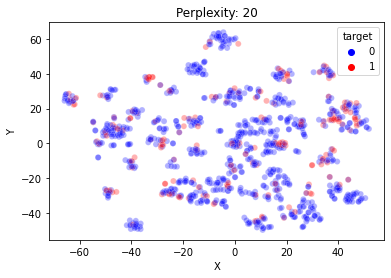

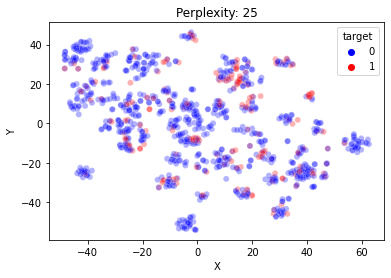

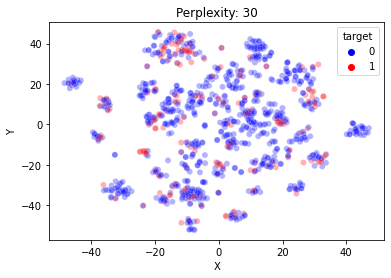

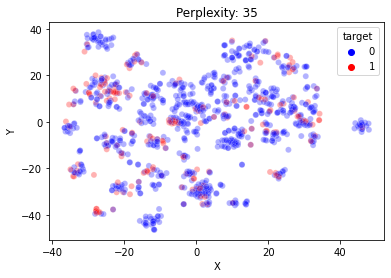

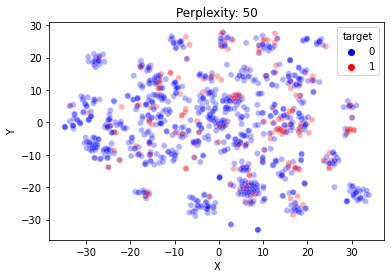

Normalized data: 


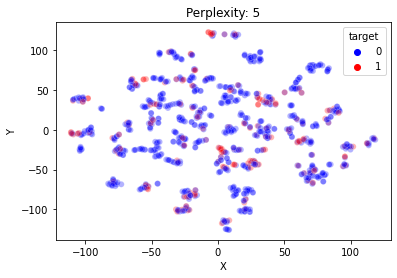

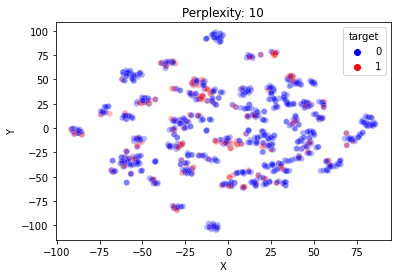

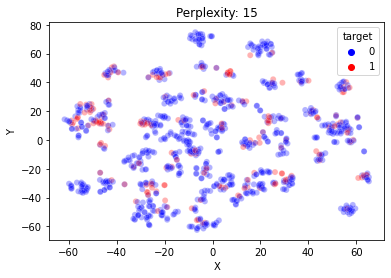

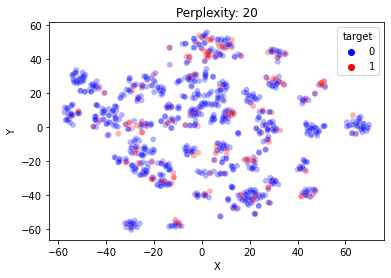

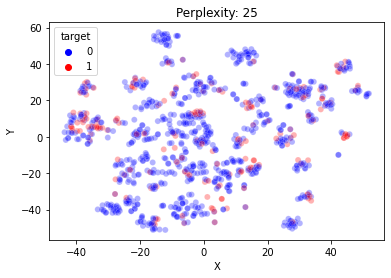

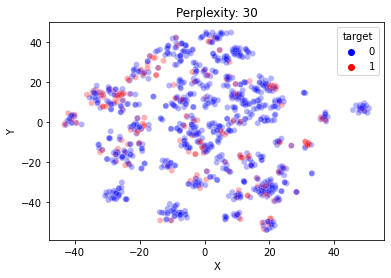

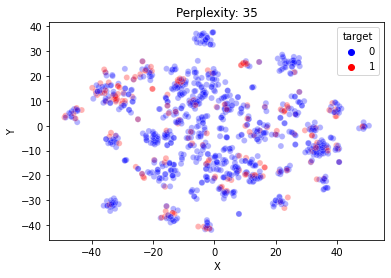

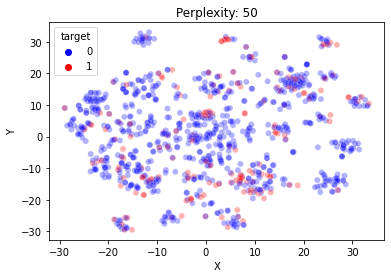

<Figure size 432x288 with 0 Axes>

In [82]:
print("Data without preprocessing: ")
plotTSNE(X_sample, y_sample, 'tsne/tsne_')

print("Standardized data: ")
plotTSNE(X_sample_standardized, y_sample, 'tsne/tsne_std_')

print("Normalized data: ")
plotTSNE(X_sample_normalized, y_sample, 'tsne/tsne_norm_')

In [84]:
# now use complete dataset for T-SNE with chosen perplexity value
tsne = TSNE(n_components=2, perplexity=15, n_iter=2000)
tsne_data = tsne.fit_transform(train_normalized)
tsne_df = pd.DataFrame(tsne_data, columns=['x', 'y'])

### PCA + T-SNE

We use the first 2 components from the PCA as input for the T-SNE which is resulting in data junks that are more connected.

In [85]:
def pca2(data):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pd.DataFrame(data = pca_result, columns = ['pca-one', 'pca-two'])

In [86]:
def plotPCA_TSNE(data, target):
    pca_df = pca2(data)
    return plotTSNE(pca_df, target, 'pca+tsne/tsne_')

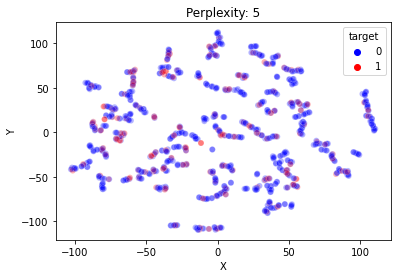

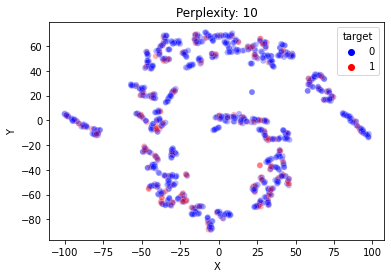

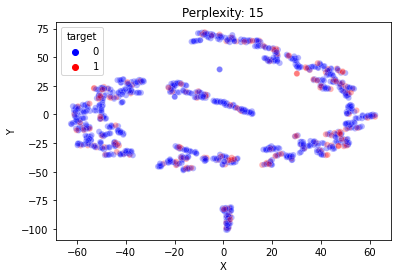

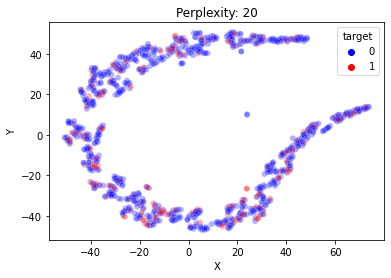

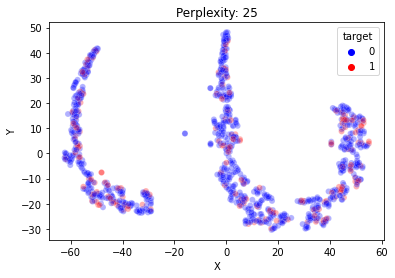

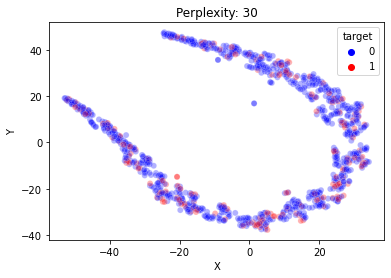

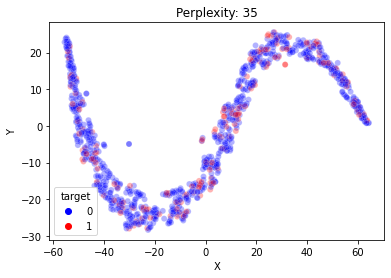

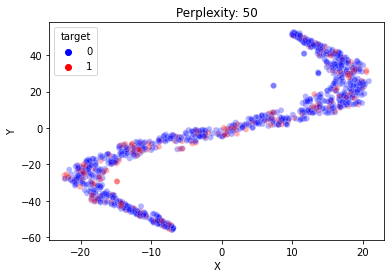

<Figure size 432x288 with 0 Axes>

In [87]:
plotPCA_TSNE(pd.DataFrame(X_sample_standardized), y_sample)

### k-Means Clustering

k-Means clustering is applied on the T-SNE data. Multiple scatter plots for different values of k get plotted.

As the data points are pretty close to each other telling the different clusters appart visually is hard. 
Judging from the resulting plots a reasonable k could lie within the range of 20-30. 

In [88]:
from sklearn.cluster import KMeans

def createKMeans(data, k):
    print("\nNumber of clusters: {0}".format(k))
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(data)
    
    countPointsPerCluster(data, kmeans, 'kmeans')
    
    visualizeClusters(data, kmeans, k, True)

In [89]:
def countPointsPerCluster(data, model, cluster_type):
    print("Points per cluster:")
    data[cluster_type] = model.labels_
    clusters = data[cluster_type].value_counts()
    
    for idx, value in enumerate(clusters):
        print("Cluster {0}: {1}".format(idx, value))

In [90]:
def visualizeClusters(data, model, k, isKmeans=False):   
    colors = sns.color_palette("hls", k)
    sns.scatterplot(x="x", y="y", hue=model.labels_, palette=colors, data=tsne_df, legend="full");
    
    if isKmeans:
        centers = model.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title("Clustering: {0}".format(len(centers)))
    plt.show()
    plt.savefig('./plots/kmeans/kmeans_'+ str(k) +'.png')


Number of clusters: 20
Points per cluster:
Cluster 0: 624
Cluster 1: 616
Cluster 2: 603
Cluster 3: 566
Cluster 4: 557
Cluster 5: 527
Cluster 6: 524
Cluster 7: 482
Cluster 8: 479
Cluster 9: 467
Cluster 10: 464
Cluster 11: 460
Cluster 12: 453
Cluster 13: 451
Cluster 14: 423
Cluster 15: 411
Cluster 16: 381
Cluster 17: 305
Cluster 18: 298
Cluster 19: 247


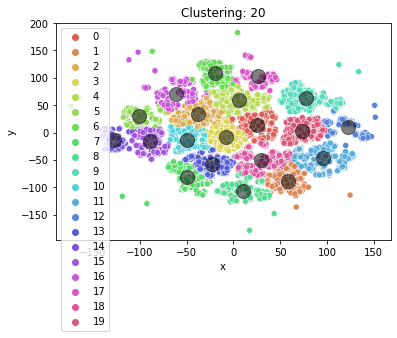


Number of clusters: 30
Points per cluster:
Cluster 0: 480
Cluster 1: 455
Cluster 2: 452
Cluster 3: 421
Cluster 4: 419
Cluster 5: 414
Cluster 6: 404
Cluster 7: 373
Cluster 8: 368
Cluster 9: 360
Cluster 10: 349
Cluster 11: 348
Cluster 12: 327
Cluster 13: 315
Cluster 14: 315
Cluster 15: 310
Cluster 16: 303
Cluster 17: 287
Cluster 18: 285
Cluster 19: 283
Cluster 20: 259
Cluster 21: 248
Cluster 22: 247
Cluster 23: 245
Cluster 24: 237
Cluster 25: 227
Cluster 26: 213
Cluster 27: 161
Cluster 28: 147
Cluster 29: 86


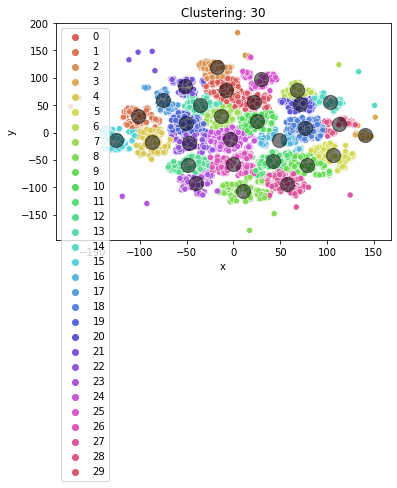

<Figure size 432x288 with 0 Axes>

In [91]:
for k in [20, 30]:
    createKMeans(tsne_df, k)

### Spectral Clustering

Similar to k-Means Clustering the data points are pretty close to each other and telling the different clusters appart visually is hard. 
Spectral clustering algorithm classifies either only a few points or very big clusters as belonging to class 'Netflix'.

In [95]:
from sklearn.cluster import SpectralClustering

def createSpectral(data, k):
    print("Number of clusters: {0}".format(k))
    spectral = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
    spectral.fit(tsne_df)
    
    countPointsPerCluster(data, spectral, 'spectral')
    
    visualizeSpectralClusters(data, spectral, k)
    #visualizeClusters(data, spectral, k)

In [96]:
def visualizeSpectralClusters(data, model, k):
    data['cluster'] = model.labels_
    sns.scatterplot(x='x', y='y', data=data, alpha=0.03, hue='cluster')
    plt.title("Clustering: {0}".format(k))
    plt.show()
    plt.savefig('./plots/spectral/spectral_'+ str(k) +'.png')

Number of clusters: 2


C:\Users\isabe\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Points per cluster:
Cluster 0: 4702
Cluster 1: 4636


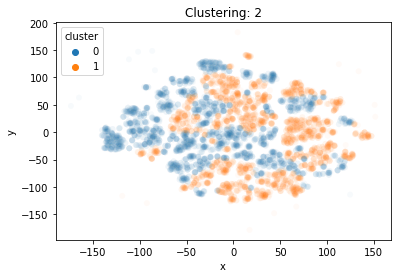

Number of clusters: 5


C:\Users\isabe\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Points per cluster:
Cluster 0: 9312
Cluster 1: 26


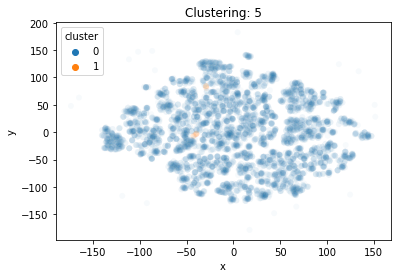

Number of clusters: 10


C:\Users\isabe\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Points per cluster:
Cluster 0: 9271
Cluster 1: 67


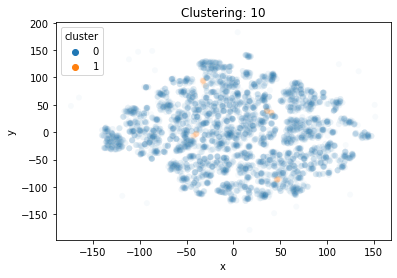

Number of clusters: 20


C:\Users\isabe\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Points per cluster:
Cluster 0: 7848
Cluster 1: 1490


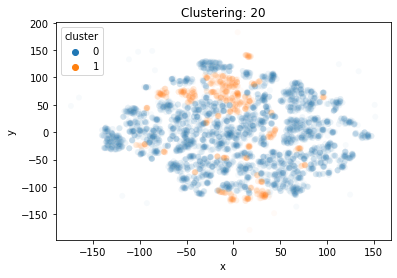

<Figure size 432x288 with 0 Axes>

In [97]:
for k in [2, 5, 10, 20]:
    createSpectral(tsne_df, k)

## Conclusion

The models for logistic regression and decision tree classification appear to perform well when only taking accuracy scores into account. However when we compare the values to the R2 scores we see that the predictions of the models are not reliable.

Similarly a Neural Networks do not seem to be suitable for prediction allthough R2 (35 %) for train and test dataset is better in comparison to the models using logistic regression and the decision tree classifier. KNN has a similar R2 for the train dataset however performs quite badly for the R2 of the test dataset (-80%).

When comparing the plots of PCA and t-SNE we can see that t-SNE can visualize data in a more clustered way that makes interpretation easier. After dimensionality reduction using PCA there are still 35 components (51 before PCA) needed for an explained variance of 95%. 

It was interesting to see the effect of combinin PCA with TSNE on the plots as interesting shapes where formed.

k-Means and spectral clustering show that there exist many clusters. A reason for the high amount of clusters might be - as previously stated - the relatively high number of components that the cluster algorithms had to deal with, even after dimensionality reduction was applied to the dataset. As the data points are pretty close to each other interpretation is quite tricky for these plots.
Intrestingly while k-Means found increasingly more clusters the higher the value for k, higher values for k showed less inpact on the amount of clusters for spectral clustering which stuck to two clusters for all the used k.

_Allthough there is a negative correlation between titles available on Netflix and Prime Video, the overall results suggest that the data available is **not suitable** for the predictions regardless of the different approaches used._

The results could most likely be improved using additional data or applying different preprocessing steps.